# Project 3
### DATA 620<br>David Moste &emsp; Euclid zhang &emsp; Samuel Reeves  <br>6/19/2021

Presentation Video Link: To Be Done

Import required libraries

In [200]:
from nltk.corpus import names
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import string

Set seed

In [201]:
random.seed(620)

Load data, change the names to lower case and shuffle the names

In [202]:
names = ([(name.lower(), 'male') for name in names.words('male.txt')] + [(name.lower(), 'female') for name in names.words('female.txt')])
random.shuffle(names)

Split data into 3 sets. The frist two set of 500 names will be used for traning and development testing. The remaining set of names will be used for performance testing <br>
During development, we will train some models using the training set and evaluate the models with different features using the development testing set. We then do another training and model evaluation by switching the traning set and development testing set. By comparing the results of the two tests, we will find the model with high accuary and stability 

In [203]:
train_dev_set_1 = names[:500]
train_dev_set_2 = names[500:1000]
train_set = train_dev_set_1
dev_test_set = train_dev_set_2
test_set = names[1000:]

In [204]:
len(train_set)

500

In [205]:
len(dev_test_set)

500

In [206]:
len(test_set)

6944

features extraction function. <br>
1. first_n: taking values from 0-3, includes the first n (0-3) letters in the feaure. If the length of the name is less than n, set the value to the length of the name
2. last_n: taking values from 0-3, includes the last n (0-3) letters in the feaure. If the length of the name is less than n, set the value to the length of the name
3. vowel_n: True/False, if Ture, includes 5 indicators showing if the name has the volwe 'a', 'e', 'i', 'o' or 'u'
4. vowel_seq: True/False, if Ture, includes the sequence of the vowels in the name. For example, the sequence for 'Thisisaword' is 'iiao'

In [207]:
def gender_features(word,first_n = 1,last_n = 1,vowel_n=False,vowel_seq=False):
    result = {}
    
    if first_n == 1:
        result['first_1'] = word[0]
    elif first_n == 2:
        result['first_1'] = word[0]
        result['first_2'] = word[0:2] if len(word) > 1 else str(len(word))
    elif first_n >= 3:
        result['first_1'] = word[0]
        result['first_2'] = word[0:2] if len(word) > 1 else str(len(word))
        result['first_3'] = word[0:3] if len(word) > 2 else str(len(word))
    
    if last_n == 1:
        result['last_1'] = word[-1]
    elif last_n == 2:
        result['last_1'] = word[-1]
        result['last_2'] = word[-2:] if len(word) > 1 else str(len(word))
    elif last_n >= 3:
        result['last_1'] = word[-1]
        result['last_2'] = word[-2:] if len(word) > 1 else str(len(word))
        result['last_3'] = word[-3:] if len(word) > 2 else str(len(word))
    
    if vowel_n:
        result['has_a'] = bool(re.search(r'a', word))
        result['has_e'] = bool(re.search(r'e', word))
        result['has_i'] = bool(re.search(r'i', word))
        result['has_o'] = bool(re.search(r'o', word))
        result['has_u'] = bool(re.search(r'u', word))
    
    if vowel_seq:
        result['vowel_sequence'] = ''.join(re.findall(r'[aeiou]', word))
    
    return result

This functions train and test models with three different algorithms: Naive Bayes, Decision Tree, Max Entropy. <br>
For each model type, train and test with all possible combination of the feaures definded in the above gender_features function <br>
The results are stored in a dict of three dataframes. Each dataframe is corresponding to one of the three model type

In [169]:
def train_dev_result():
    #set up empty dataframes to store the results
    NB_summary = pd.DataFrame(columns = ['first_n', 'last_n','vowel_n','vowel_seq','train_accuracy','dev_test_accuracy'])
    DT_summary = pd.DataFrame(columns = ['first_n', 'last_n','vowel_n','vowel_seq','train_accuracy','dev_test_accuracy'])
    ME_summary = pd.DataFrame(columns = ['first_n', 'last_n','vowel_n','vowel_seq','train_accuracy','dev_test_accuracy'])
    
    #index of the next row to enter the test result
    index_counter = 0
    
    #loop: first_n 
    for i in range(0,4):
        #loop: last_n
        for j in range(0,4):
            #loop: vowel_n
            for vowel_n in [True,False]:
                #loop: vowel_seq
                for vowel_seq in [True,False]:
                    #skip the situation with no feature is selected
                    if i==0 & j == 0 & (not vowel_n) & (not vowel_seq):
                        continue
                    #generate training features
                    train_feature = [(gender_features(n,first_n=i,last_n=j,vowel_n = vowel_n,vowel_seq = vowel_seq), 
                                      g) for (n,g) in train_set]
                    #generate testing features
                    dev_test_feature = [(gender_features(n,first_n=i,last_n=j,vowel_n = vowel_n,vowel_seq = vowel_seq), 
                                         g) for (n,g) in dev_test_set]
                    #model training
                    NBclassifier = nltk.NaiveBayesClassifier.train(train_feature)
                    DTclassifier = nltk.DecisionTreeClassifier.train(train_feature)
                    MEclassifier = nltk.MaxentClassifier.train(train_feature,'IIS',trace  = 0)
                    #record the feature option values, the result accuracy using the training set, 
                    #and the result accuracy using the development testing set
                    NB_summary.loc[index_counter] = [i,j,vowel_n,vowel_seq,
                                              nltk.classify.accuracy(NBclassifier, train_feature),
                                              nltk.classify.accuracy(NBclassifier, dev_test_feature)]
                    DT_summary.loc[index_counter] = [i,j,vowel_n,vowel_seq,
                                              nltk.classify.accuracy(DTclassifier, train_feature),
                                              nltk.classify.accuracy(DTclassifier, dev_test_feature)]
                    ME_summary.loc[index_counter] = [i,j,vowel_n,vowel_seq,
                                              nltk.classify.accuracy(MEclassifier, train_feature),
                                              nltk.classify.accuracy(MEclassifier, dev_test_feature)]
                    #index increasement
                    index_counter = index_counter + 1
                    #sorting results by the accuracy using the development testing set
                    NB_summary = NB_summary.sort_values(by = 'dev_test_accuracy', ascending = False)
                    DT_summary = DT_summary.sort_values(by = 'dev_test_accuracy', ascending = False)
                    ME_summary = ME_summary.sort_values(by = 'dev_test_accuracy', ascending = False)
    #result the result dataframes in a dict
    return {'Naive_Bayes':NB_summary, 'Decision_Tree':DT_summary, 'Max_Entropy':ME_summary}

execute the training and evaluation function

In [170]:
result_1 = train_dev_result()

show the results of three different model types

In [210]:
print('Naive_Bayes')
display(result_1['Naive_Bayes'].head(10))
print('Decision_Tree')
display(result_1['Decision_Tree'].head(10))
print('Max_Entropy')
display(result_1['Max_Entropy'].head(10))

Naive_Bayes


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
11,1,2,False,False,0.848,0.794
15,1,3,False,False,0.914,0.788
13,1,3,True,False,0.900,0.786
40,3,2,True,True,0.922,0.782
31,2,3,False,False,0.928,0.782
9,1,2,True,False,0.850,0.782
44,3,3,True,True,0.946,0.780
29,2,3,True,False,0.918,0.778
27,2,2,False,False,0.878,0.778
28,2,3,True,True,0.912,0.778


Decision_Tree


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
7,1,1,False,False,0.878,0.782
5,1,1,True,False,0.930,0.764
21,2,1,True,False,0.966,0.750
23,2,1,False,False,0.936,0.746
11,1,2,False,False,0.962,0.724
8,1,2,True,True,0.980,0.724
10,1,2,False,True,0.980,0.724
9,1,2,True,False,0.974,0.720
27,2,2,False,False,0.984,0.718
24,2,2,True,True,0.988,0.716


Max_Entropy


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
44,3,3,True,True,0.996,0.784
45,3,3,True,False,0.996,0.780
46,3,3,False,True,0.998,0.776
47,3,3,False,False,0.998,0.774
42,3,2,False,True,0.992,0.770
40,3,2,True,True,0.990,0.762
28,2,3,True,True,0.996,0.762
25,2,2,True,False,0.946,0.762
15,1,3,False,False,0.980,0.762
9,1,2,True,False,0.884,0.760


Naive Bayes has higher dev_test_accuracy <br>
Max Entropy has higher train_accuracy, it seems that it is overfitting<br>
Decision_Tree has average dev_test_accuracy and train_accuracy. It performs the best when using only the first letter and the last letter

Perform another testing and evaluation by switching the training set and development testing set

In [172]:
train_set = train_dev_set_2
dev_test_set = train_dev_set_1

In [174]:
result_2 = train_dev_result()

In [211]:
print('Naive_Bayes')
display(result_2['Naive_Bayes'].head(10))
print('Decision_Tree')
display(result_2['Decision_Tree'].head(10))
print('Max_Entropy')
display(result_2['Max_Entropy'].head(10))

Naive_Bayes


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
30,2,3,False,True,0.920,0.784
14,1,3,False,True,0.918,0.782
12,1,3,True,True,0.904,0.778
9,1,2,True,False,0.866,0.776
13,1,3,True,False,0.896,0.776
29,2,3,True,False,0.916,0.774
15,1,3,False,False,0.906,0.772
43,3,2,False,False,0.926,0.772
42,3,2,False,True,0.940,0.772
31,2,3,False,False,0.920,0.770


Decision_Tree


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
7,1,1,False,False,0.888,0.770
6,1,1,False,True,0.970,0.736
4,1,1,True,True,0.970,0.736
5,1,1,True,False,0.932,0.728
26,2,2,False,True,0.998,0.724
24,2,2,True,True,0.998,0.724
27,2,2,False,False,0.994,0.720
25,2,2,True,False,0.994,0.720
9,1,2,True,False,0.976,0.716
11,1,2,False,False,0.962,0.714


Max_Entropy


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
9,1,2,True,False,0.898,0.764
11,1,2,False,False,0.896,0.764
5,1,1,True,False,0.820,0.760
46,3,3,False,True,0.998,0.758
13,1,3,True,False,0.966,0.758
15,1,3,False,False,0.970,0.754
30,2,3,False,True,0.998,0.754
7,1,1,False,False,0.810,0.752
31,2,3,False,False,0.998,0.752
28,2,3,True,True,0.998,0.750


For Naive Bayes and Max Entropy, the best feature selections are different in the second test. Decision Tree is quite stable. We can see that the Decision Tree model using only the first letter and the last letter still performs the best. Moreover, the Decision_Tree models provide relatively good accuracies

We will select the Decision Tree model with the first letter and the last letter as features to be our current optimal model.
We will then try to improve the model

Set up the optimal model and print out the prediction that the model has done incorrectly

In [233]:
train_feature = [(gender_features(n,1,1),g) for (n,g) in train_set]
dev_test_feature = [(gender_features(n,1,1),g) for (n,g) in dev_test_set]
DTclassifier = nltk.DecisionTreeClassifier.train(train_feature)

In [234]:
errors = []
for (name, tag) in dev_test_set:
    guess = DTclassifier.classify(gender_features(name))
    if guess != tag:
        errors.append( (tag, guess, name) )

In [235]:
for (tag, guess, name) in sorted(errors): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=female   guess=male     name=arlyn                         
correct=female   guess=male     name=austin                        
correct=female   guess=male     name=bird                          
correct=female   guess=male     name=debor                         
correct=female   guess=male     name=dory                          
correct=female   guess=male     name=fan                           
correct=female   guess=male     name=gilly                         
correct=female   guess=male     name=gretchen                      
correct=female   guess=male     name=hally                         
correct=female   guess=male     name=harriet                       
correct=female   guess=male     name=hildy                         
correct=female   guess=male     name=kipp                          
correct=female   guess=male     name=lib                           
correct=female   guess=male     name=margit                        
correct=female   guess=male     name=marlo      

We can see that a lot more females have a name starts with 'ro' or 'sh' and a lot more males have a name starts with 'wa'

In [215]:
dev_test_df = pd.DataFrame(dev_test_set, columns = ['name', 'gender'])

names start with 'ro'


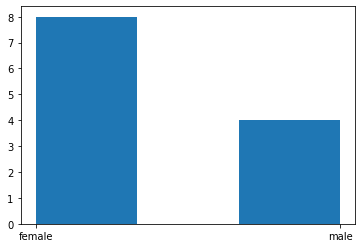

In [237]:
print('names start with \'ro\'')
data = dev_test_df.loc[[name.startswith('ro') for name in dev_test_df['name']],'gender']
sum(data == 'male')
plt.hist(data,bins=3)
plt.show()

From the tests above, the Decision Tree model including the first 2 letters in the features doesn't have better performance. But what if we include only specific combinations of 2 letters such as 'ro' and 'sh'?

Let's check if there are other combinations of 2 letters in the begining of a name that may increase the probaility of classifying the correct gender

In [228]:
#all combination of 2 letters
first_2_comb = [u+l for u in list(string.ascii_lowercase) for l in list(string.ascii_lowercase)]

#Threhold for selecting the combination of 2 letters. For example, if x percent of the names start with 'ro' are males
# and y percent of the names start with 'ro' are females and the difference between x and y are higher than the threhold, 
#we will include 'startswith_ro' in feature result 
threshold = 0.35

first_2_table = pd.DataFrame(columns = ['first_2', 'male','female','male_percent','female_percent'])
index_counter = 0

for first_2 in first_2_comb:
    data = dev_test_df.loc[[name.startswith(first_2) for name in dev_test_df['name']],'gender']
    if len(data) == 0:
        continue
    if (sum(data == 'male') < 3) & (sum(data == 'female') < 3):
        continue        
    if abs((sum(data == 'male') - sum(data == 'female'))/len(data)) > threshold:
        first_2_table.loc[index_counter] = [first_2,sum(data == 'male'),sum(data == 'female'),
                                           sum(data == 'male')/len(data),sum(data == 'female')/len(data)]
        index_counter = index_counter + 1

In [229]:
first_2_table

,first_2,male,female,male_percent,female_percent
0,am,1,4,0.200000,0.800000
1,an,2,10,0.166667,0.833333
2,ar,1,5,0.166667,0.833333
3,au,0,3,0.000000,1.000000
4,ba,1,4,0.200000,0.800000
5,be,2,8,0.200000,0.800000
6,bi,0,3,0.000000,1.000000
7,br,1,3,0.250000,0.750000
8,ca,0,23,0.000000,1.000000
9,co,2,6,0.250000,0.750000


Create a new feature genderation function and include the additional features about the specific combinations of 2 letters as the starting of a name

In [230]:
def gender_features2(word):
    result = gender_features(word,1,3)
    for first_2 in first_2_table['first_2']:
        result['startswith_' + first_2] = word.startswith(first_2)
    return result

Train and test our new model

In [232]:
train_feature = [(gender_features2(n),g) for (n,g) in train_set]
dev_test_feature = [(gender_features2(n),g) for (n,g) in dev_test_set]
DTclassifier = nltk.DecisionTreeClassifier.train(train_feature)
nltk.classify.accuracy(NBclassifier, dev_test_feature)

0.768

Adding more feaures do not improve our model

Why does the model perform better with less features? Our training set is too small. We have around 8 thousands of names in the entire data set and there are more names in the world that are not included. We are training our model with only 500 names. If we are using more features, some feature values may not be seen in our training dataset. It will be hard for the model to predict when it see such feature values in the test data.

Let's train our optimal model with both the training and development testing data, and calcualte the accuracy using the test data

In [240]:
train_feature = [(gender_features2(n),g) for (n,g) in (train_set+dev_test_set)]
test_feature = [(gender_features2(n),g) for (n,g) in test_set]
DTclassifier = nltk.DecisionTreeClassifier.train(train_feature)
nltk.classify.accuracy(NBclassifier, test_feature)

0.7756336405529954

The result again shows that the Decision Tree model has good and stable performance

In [241]:
train_set = names[:6000]
dev_test_set = names[6000:]
result_3 = train_dev_result()

In [244]:
print('Naive_Bayes')
display(result_3['Naive_Bayes'].head(10))
print('Decision_Tree')
display(result_3['Decision_Tree'].head(10))
print('Max_Entropy')
display(result_3['Max_Entropy'].head(10))

Naive_Bayes


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
45,3,3,True,False,0.877833,0.838477
44,3,3,True,True,0.875833,0.833848
47,3,3,False,False,0.883333,0.833848
40,3,2,True,True,0.862167,0.828704
46,3,3,False,True,0.879500,0.828704
41,3,2,True,False,0.863667,0.824074
42,3,2,False,True,0.866500,0.822016
29,2,3,True,False,0.844667,0.819959
28,2,3,True,True,0.843500,0.816872
31,2,3,False,False,0.848000,0.816872


Decision_Tree


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
9,1,2,True,False,0.906667,0.778292
11,1,2,False,False,0.874333,0.774691
5,1,1,True,False,0.838833,0.770576
8,1,2,True,True,0.935333,0.765947
10,1,2,False,True,0.935333,0.765947
13,1,3,True,False,0.945333,0.765432
4,1,1,True,True,0.899500,0.764918
6,1,1,False,True,0.899500,0.764918
15,1,3,False,False,0.933833,0.763889
7,1,1,False,False,0.802667,0.763889


Max_Entropy


,first_n,last_n,vowel_n,vowel_seq,train_accuracy,dev_test_accuracy
40,3,2,True,True,0.913000,0.826646
42,3,2,False,True,0.914500,0.825103
44,3,3,True,True,0.936833,0.818930
41,3,2,True,False,0.905000,0.817901
45,3,3,True,False,0.931333,0.815844
43,3,2,False,False,0.906167,0.815844
46,3,3,False,True,0.939500,0.814815
38,3,1,False,True,0.901333,0.811728
36,3,1,True,True,0.897500,0.811728
47,3,3,False,False,0.934000,0.810700


The top models in all three model types have more features than the results with small data sets. Both Naive Bayes and Max Entropy are benefited by larger data set. The performance of Decision Tree is not affected by a lot. The top models for Decision Tree is still using less features than Naive Bayes and Max Entropy.

Conclusion: for small training data set, Decision Tree model with fewer features performs better. For large training data set, Naive Bayes and Max Entropy with wisely selected features are better choice. Between Naive Bayes and Max Entropy, Naive Bayes works better in this case since they have similar performance but the time processing Max Entropy is significantly larger